
# Feature Selection with Random Forest


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


1. RAF Feature Importance w/o Normalization


2. RAF Feature Importance w/ Normalization


3. RAF Feature Importance w/ Normalization w/ Lagged Observation


Custom functions to re-use  (


add_technical_indicator_features  
fwdchain_splitdata  
add_label  
get_label  
remove_label  



Do for 10 stock and create table panel

In [1]:
import talib
from talib.abstract import *
import numpy as np
import pandas as pd
import datetime as dt
import sys, os, os.path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.mode.chained_assignment = None # Suppress warning

## Pilot Dataset

| Ticker | Industry/Sector                              | MktCap  | SET50 | Dataset Series-ID |
|--------|----------------------------------------------|---------|-------|-------------------|
| SCB    | Financials/Banking                           | 305000  | Y     | HS-1              |
| KBANK  | Financials/Banking                           | 276000  | Y     | HS-2              |
| AOT    | Services/Transportation & Logistics          | 946000  | Y     | HS-3              |
| BTS    | Services/Transportation & Logistics          | 134000  | Y     | HS-4              |
| AP     | Property & Construction/Property Development | 24000   | N     | HS-5              |
| LH     | Property & Construction/Property Development | 97000   | Y     | HS-6              |
| CPF    | Agro & Food Industry/Food & Beverage         | 243000  | Y     | HS-7              |
| KSL    | Agro & Food Industry/Food & Beverage         | 10000   | N     | HS-8              |
| PTT    | Resources/Energy & Utilities                 | 1228000 | Y     | HS-9              |
| RATCH  | Resources/Energy & Utilities                 | 83000   | Y     | HS-10             |

In [2]:
# Load set of stocks from dataset

EXPERIMENT_HOME = os.path.join("..","ml_home")
sys.path.insert(0, EXPERIMENT_HOME)

DATA_HOME = os.path.join("..","dataset","historical")

symbols = ["SCB","KBANK","AOT","BTS","AP","LH","CPF","KSL","PTT","RATCH"]
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

# Select single stock series for analysis    
ticker = "SCB"
df = data[ticker]
df.index = pd.to_datetime(df.index)

period_start='2014-01-01'
period_end='2014-12-31'

daily = df[period_start:period_end]
daily

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,142.0,131.5,141.5,131.5,14726700.0,98.861626
2014-01-03,135.5,131.0,132.0,132.5,15410800.0,99.613434
2014-01-06,140.0,130.5,132.0,140.0,12798300.0,105.251930
2014-01-07,144.0,139.0,141.0,144.0,9352800.0,108.259125
2014-01-08,144.5,140.0,143.5,140.5,10750100.0,105.627823
...,...,...,...,...,...,...
2014-12-24,186.0,184.0,185.0,184.5,1868200.0,143.104462
2014-12-25,184.0,181.5,182.5,183.0,2521600.0,141.940994
2014-12-26,184.5,181.0,182.0,184.5,2458300.0,143.104462


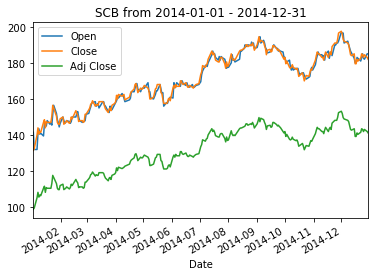

In [3]:
daily[['Open','Close','Adj Close']].plot(title="%s from %s - %s" % (ticker, period_start, period_end))

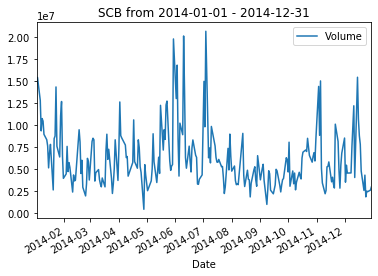

In [4]:
daily[['Volume']].plot(title="%s from %s - %s" % (ticker, period_start, period_end))

# Compute Volatility

Refer to Eikon_Volatility_StDev_5d.ipynb




## Daily Price Variation

(High - Low) / Close

Method referenced:

https://finance.zacks.com/calculate-daily-price-variation-stocks-8299.html



# Compute Technical Indicators

See TechnicalAnalysis/ folder for each indicator details.


## SMA

Simple n-day moving average. Average of the price over the calculation period.

## WMA

Weight average of last n-values. Use 14 days. So n=14 in [2]. n=10 in [9]

## EMA

Exponential Moving Average (EMA)
The weight of past prices decrease exponentially. [3] change value according to the input window being tested.

## RSI

Is an oscillator. Has value between 0-100. Evaluate magnitude of value change to assess overbought or oversold.
[2] calculate RSI using up/down and the end of period. Use n previouse day. [3] derive RSI from EMA and DM (direction movement indicator constructed from max function).
[9] use n=10,

## MOM

Momentum  
Indicate speed of the rise or fall in prices. [2] uses n+1; Security price rate of change. [11] sets to 10.


## Stochastic K%

the Stochastic Oscillator is used for three things; Identifying overbought and oversold levels, spotting divergences and also identifying bull and bear set ups or signals. https://www.tradingview.com/support/solutions/43000502332-stochastic-stoch/
See the calculation details.

## Stochastic D%

Momentum indicator over a particular period ... Indicate overbought or oversold.  
Is EMA(3) of Stochastic K%

In [5]:
# Note the use of Close instead of Adj Close for TI calculation.
inputs = {
    'open': daily["Open"],
    'high': daily["High"],
    'low': daily["Low"],
    'close': daily["Close"],
    'volume': daily["Volume"]
}

n = 5
daily_sma = SMA(inputs, timeperiod=n)
daily.loc[:,("SMA")] = daily_sma.tolist()    

n = 5
daily_wma = WMA(inputs, timeperiod=n)
daily.loc[:,("WMA")] = daily_wma.tolist()  

n = 5
daily_ema = EMA(inputs, timeperiod=n)
daily.loc[:,("EMA")] = daily_sma.tolist()

n = 5
rsi_5d = RSI(inputs, timeperiod=n)
n = 10
rsi_10d = RSI(inputs, timeperiod=n)
n = 15
rsi_15d = RSI(inputs, timeperiod=n)
daily.loc[:,("RSI-5")] = rsi_5d.tolist()
daily.loc[:,("RSI-10")] = rsi_10d.tolist()
daily.loc[:,("RSI-15")] = rsi_15d.tolist()

n = 10
mom_t10 = MOM(inputs, timeperiod=n)
daily.loc[:,("MOM-10")] = mom_t10.tolist()

# STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# See documentation in C code.
slowk, slowd = STOCH(inputs, prices=['high', 'low', 'close']) # No need for period.!! Check out the C documentation.
daily.loc[:,("Stoch-K")] = slowk.tolist()
daily.loc[:,("Stoch-D")] = slowd.tolist()

# FF-24 Daily Price Variation
daily["DailyPriceVariation"] = (daily["High"] - daily["Low"]) / daily["Close"]

# FF-25 ~ use VWAP?
daily['PriceStDev-5d'] = df['Close'].rolling(5).std() # Short cut available from pandas

daily.head()

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,EMA,RSI-5,RSI-10,RSI-15,MOM-10,Stoch-K,Stoch-D,DailyPriceVariation,PriceStDev-5d
Date,,,,,,,,,,,,,,,,,
2014-01-02,142.0,131.5,141.5,131.5,14726700.0,98.861626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079848,NaN
2014-01-03,135.5,131.0,132.0,132.5,15410800.0,99.613434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033962,NaN
2014-01-06,140.0,130.5,132.0,140.0,12798300.0,105.251930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.067857,NaN
2014-01-07,144.0,139.0,141.0,144.0,9352800.0,108.259125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034722,NaN
2014-01-08,144.5,140.0,143.5,140.5,10750100.0,105.627823,137.7,139.666667,137.7,NaN,NaN,NaN,NaN,NaN,NaN,0.032028,5.43829


In [6]:
daily.dropna(inplace=True)
daily.describe().T

,count,mean,std,min,25%,50%,75%,max
High,230.0,1.737413e+02,1.393973e+01,147.000000,1.625000e+02,1.755000e+02,1.860000e+02,1.990000e+02
Low,230.0,1.709478e+02,1.389910e+01,143.500000,1.591250e+02,1.725000e+02,1.828750e+02,1.960000e+02
Open,230.0,1.723239e+02,1.403600e+01,144.500000,1.605000e+02,1.747500e+02,1.845000e+02,1.970000e+02
Close,230.0,1.724652e+02,1.392819e+01,146.000000,1.601250e+02,1.747500e+02,1.845000e+02,1.975000e+02
Volume,230.0,6.039598e+06,3.325518e+06,460600.000000,3.781450e+06,5.278250e+06,7.410675e+06,2.064500e+07
Adj Close,230.0,1.324702e+02,1.193571e+01,109.762726,1.224560e+02,1.353481e+02,1.430166e+02,1.531877e+02
SMA,230.0,1.721652e+02,1.393672e+01,146.800000,1.610000e+02,1.740500e+02,1.839750e+02,1.952000e+02
WMA,230.0,1.722683e+02,1.390677e+01,146.966667,1.611167e+02,1.742000e+02,1.840167e+02,1.957667e+02
EMA,230.0,1.721652e+02,1.393672e+01,146.800000,1.610000e+02,1.740500e+02,1.839750e+02,1.952000e+02
RSI-5,230.0,5.474001e+01,1.960654e+01,14.860899,4.030661e+01,5.538662e+01,6.972630e+01,9.462335e+01


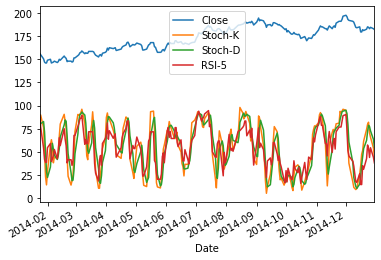

In [7]:
daily[['Close','Stoch-K','Stoch-D','RSI-5']].plot()

# Label Data: Add future value to column

In [8]:
def add_label(df_daily):
    """Add label to daily price dataframe. Do this before train/test split."""
    df_daily['1-day'] = df_daily['Close'].shift(-1) # Tomorrow's price
    df_daily['3-day'] = df_daily['Close'].shift(-3) # 
    df_daily['5-day'] = df_daily['Close'].shift(-3) # Price in five days
    df_daily['7-day'] = df_daily['Close'].shift(-3) # 
    df_daily['10-day'] = df_daily['Close'].shift(-3) # Price in ten days
    df_daily['15-day'] = df_daily['Close'].shift(-3) # 
    df_daily['20-day'] = df_daily['Close'].shift(-3) # 
    df_daily['30-day'] = df_daily['Close'].shift(-3) # Price in 30 days
    return df_daily

def get_label(df):
    """Get label columns from training set. Do this before remove label."""
    labels = ['1-day', '3-day', '5-day', '7-day', '10-day', '15-day', '20-day', '30-day']
    return df[labels]

def remove_label(df):
    """Remove label from training dataset. So we don't leak information."""
    labels = ['1-day', '3-day', '5-day', '7-day', '10-day', '15-day', '20-day', '30-day']
    df.drop(labels, axis=1, inplace=True) # Drop columns defined above
    return df

daily = add_label(daily)
daily

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,EMA,RSI-5,...,DailyPriceVariation,PriceStDev-5d,1-day,3-day,5-day,7-day,10-day,15-day,20-day,30-day
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-23,156.5,150.5,151.5,156.5,14332200.0,117.656586,149.6,151.100000,149.6,87.410327,...,0.038339,4.144273,155.0,147.0,147.0,147.0,147.0,147.0,147.0,147.0
2014-01-24,157.0,153.5,156.5,155.0,7609400.0,116.528893,151.2,152.900000,151.2,77.410551,...,0.022581,4.424364,150.5,146.0,146.0,146.0,146.0,146.0,146.0,146.0
2014-01-27,152.5,150.5,152.0,150.5,6392900.0,113.145844,151.9,152.666667,151.9,54.171080,...,0.013289,3.830796,147.0,146.0,146.0,146.0,146.0,146.0,146.0,146.0
2014-01-28,149.5,145.5,148.5,147.0,11064100.0,110.514511,151.9,151.033333,151.9,41.932252,...,0.027211,3.830796,146.0,149.0,149.0,149.0,149.0,149.0,149.0,149.0
2014-01-29,147.0,145.0,147.0,146.0,12681700.0,109.762726,151.0,149.066667,151.0,38.801406,...,0.013699,4.677072,146.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,186.0,184.0,185.0,184.5,1868200.0,143.104462,183.0,183.600000,183.0,54.064823,...,0.010840,1.695582,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0
2014-12-25,184.0,181.5,182.5,183.0,2521600.0,141.940994,183.2,183.600000,183.2,44.071011,...,0.013661,1.604681,184.5,182.0,182.0,182.0,182.0,182.0,182.0,182.0
2014-12-26,184.5,181.0,182.0,184.5,2458300.0,143.104462,183.9,184.033333,183.9,54.568462,...,0.018970,1.083974,183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Split Data 80/20



In [9]:
def split_data_fwdchaining(daily):

    dataset_total_days = len(daily)
    traintest_split_at = int(dataset_total_days*0.8)
    split_date = daily[traintest_split_at:traintest_split_at+1].index.strftime("%Y-%m-%d").values[0]
    print('Data series total days:', dataset_total_days)
    print('Data series train/test split at:', traintest_split_at)
    print('Data series train/test split at:', split_date)

    train = daily[:traintest_split_at]
    test = daily[traintest_split_at:]

    train_from = train.head(1).index.strftime("%Y-%m-%d").values[0]
    train_to = train.tail(1).index.strftime("%Y-%m-%d").values[0]

    test_from = test.head(1).index.strftime("%Y-%m-%d").values[0]
    test_to = test.tail(1).index.strftime("%Y-%m-%d").values[0]

    print("Training set: %s - %s" % (train_from, train_to))
    print("Test set: %s - %s" % (test_from, test_to))
    
    return train, test

# Get training set and test set from daily dataset
train, test = split_data_fwdchaining(daily)

Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30


In [10]:


train.tail(1).index.strftime("%Y-%m-%d").values[0]

'2014-10-22'

# Prepare Label / Remove Label from Training Set

Three plots in one figure

https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots

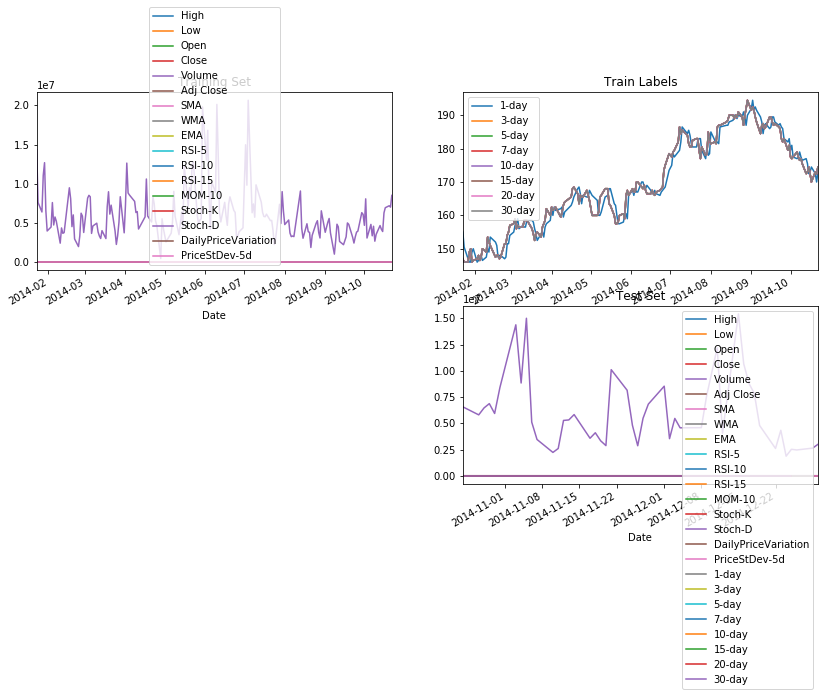

In [11]:

train_labels = get_label(train)

train = remove_label(train)


plt.figure(1)
plt.subplot(2,2,1)
train.plot(ax=plt.gca(), title="Training Set", figsize=(14,8)) #no need to specify for first axis
plt.subplot(2,2,2)
train_labels.plot(ax=plt.gca(),title="Train Labels")
plt.subplot(2,2,4)
test.plot(ax=plt.gca(), title="Test Set")



In [12]:
# Convert all to numpy array
# Labels are the values we want to predict
labels = np.array(train_labels['1-day'])

# Saving feature names for later use
feature_list = list(train.columns)

features = np.array(train)


train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

# Train/Validation Set

0.25 validation

In [13]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Testing Features Shape: (46, 17)
Testing Labels Shape: (46,)


# Fit RF Model

In [14]:


    
rf = RandomForestRegressor(n_estimators = 10, criterion = 'mae', random_state = 1234)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)

# Variable Importaince

Feature ranking:
1. feature 1 (0.190990)
2. feature 3 (0.175246)
3. feature 0 (0.171787)
4. feature 5 (0.158914)
5. feature 7 (0.123716)
6. feature 2 (0.049383)
7. feature 6 (0.046100)
8. feature 8 (0.015693)
9. feature 13 (0.012189)
10. feature 16 (0.011170)
11. feature 14 (0.010300)
12. feature 12 (0.010147)
13. feature 4 (0.007133)
14. feature 15 (0.005409)
15. feature 11 (0.004891)
16. feature 10 (0.003571)
17. feature 9 (0.003362)


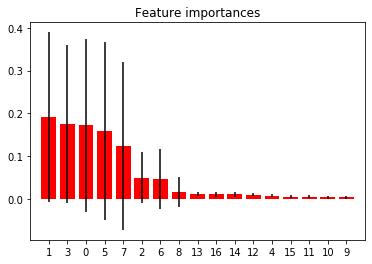

In [15]:
# Variable importance
#   https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_

X = train_features

std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

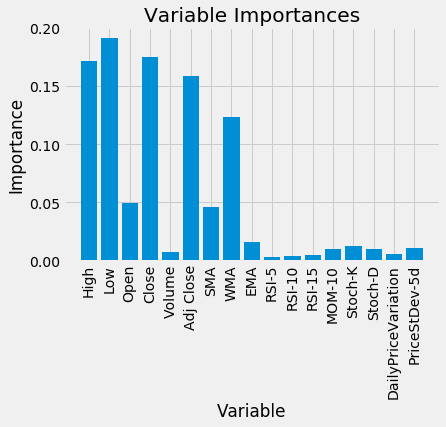

In [16]:

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Prediction Performance

In [17]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Points')

Mean Absolute Error: 1.92 Points


In [18]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
print("MAPE:", round(np.mean(mape),4))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

MAPE: 1.1527
Accuracy: 98.85 %.


# Table Panel for 10-Stock

Summary statistics of indicators

Helper functions:

prediction_perf(rf, test_features, test_labels)  
plot_var_importance(rf, train_features)  

In [19]:
# Variable Importance w.r.t. to Forecast Horizon


def train_model(train, train_labels, target_horizon='1-day'):

    # Convert all to numpy array
    # Labels are the values we want to predict
    # labels = np.array(train_labels['1-day'])
    labels = np.array(train_labels[target_horizon])

    # Saving feature names for later use
    feature_list = list(train.columns)

    features = np.array(train)

    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Validation Features Shape:', test_features.shape)
    print('Validation Labels Shape:', test_labels.shape)
    
    
    rf = RandomForestRegressor(n_estimators = 10, criterion = 'mae', random_state = 1234)
    rf.fit(train_features, train_labels)
    return rf, train_features

def prediction_perf(rf, test_features, test_labels):
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'Points')
    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)
    print("MAPE:", round(np.mean(mape),4))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    
def plot_var_importance(rf, train_features, target_desc=""):
    # Variable importance
    #   https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    importances = rf.feature_importances_
    X = train_features

    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    # Set the style
    # plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')
    # Axis labels and title
    plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances: ' + target_desc);

1-day
Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30
Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Validation Features Shape: (46, 17)
Validation Labels Shape: (46,)
Feature ranking:
1. feature 1 (0.190990)
2. feature 3 (0.175246)
3. feature 0 (0.171787)
4. feature 5 (0.158914)
5. feature 7 (0.123716)
6. feature 2 (0.049383)
7. feature 6 (0.046100)
8. feature 8 (0.015693)
9. feature 13 (0.012189)
10. feature 16 (0.011170)
11. feature 14 (0.010300)
12. feature 12 (0.010147)
13. feature 4 (0.007133)
14. feature 15 (0.005409)
15. feature 11 (0.004891)
16. feature 10 (0.003571)
17. feature 9 (0.003362)


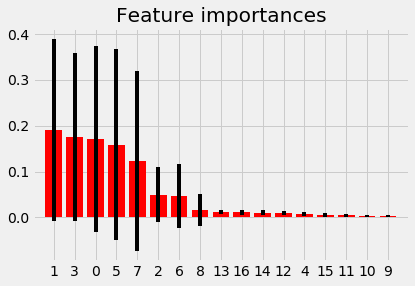

3-day
Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30
Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Validation Features Shape: (46, 17)
Validation Labels Shape: (46,)
Feature ranking:
1. feature 0 (0.225747)
2. feature 1 (0.193748)
3. feature 3 (0.152291)
4. feature 5 (0.128996)
5. feature 7 (0.076558)
6. feature 2 (0.049137)
7. feature 14 (0.028148)
8. feature 4 (0.021435)
9. feature 11 (0.018623)
10. feature 8 (0.017328)
11. feature 15 (0.016423)
12. feature 13 (0.015720)
13. feature 9 (0.013367)
14. feature 12 (0.012791)
15. feature 16 (0.011989)
16. feature 6 (0.009657)
17. feature 10 (0.008042)


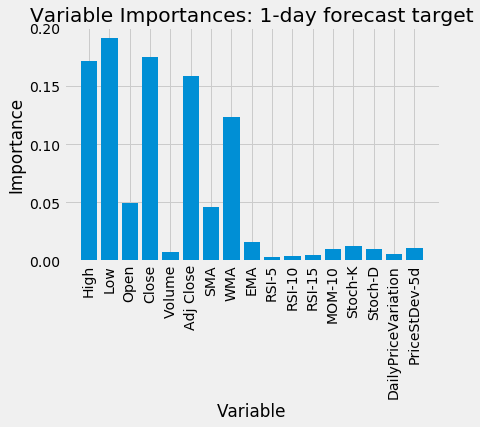

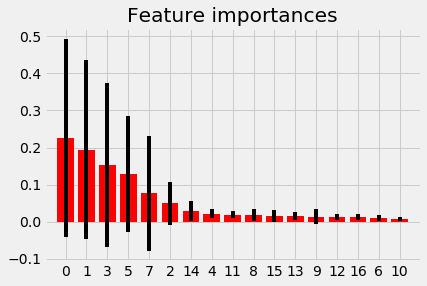

5-day
Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30
Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Validation Features Shape: (46, 17)
Validation Labels Shape: (46,)
Feature ranking:
1. feature 0 (0.225747)
2. feature 1 (0.193748)
3. feature 3 (0.152291)
4. feature 5 (0.128996)
5. feature 7 (0.076558)
6. feature 2 (0.049137)
7. feature 14 (0.028148)
8. feature 4 (0.021435)
9. feature 11 (0.018623)
10. feature 8 (0.017328)
11. feature 15 (0.016423)
12. feature 13 (0.015720)
13. feature 9 (0.013367)
14. feature 12 (0.012791)
15. feature 16 (0.011989)
16. feature 6 (0.009657)
17. feature 10 (0.008042)


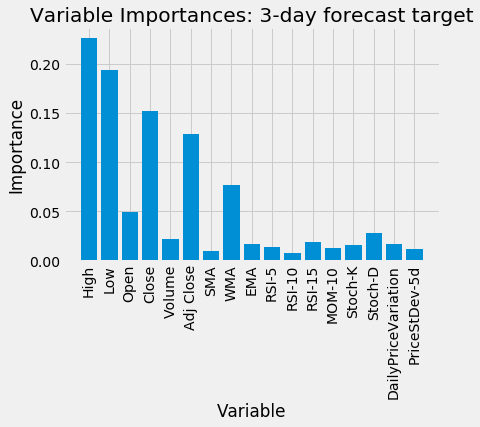

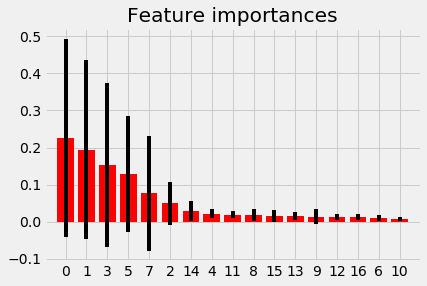

10-day
Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30
Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Validation Features Shape: (46, 17)
Validation Labels Shape: (46,)
Feature ranking:
1. feature 0 (0.225747)
2. feature 1 (0.193748)
3. feature 3 (0.152291)
4. feature 5 (0.128996)
5. feature 7 (0.076558)
6. feature 2 (0.049137)
7. feature 14 (0.028148)
8. feature 4 (0.021435)
9. feature 11 (0.018623)
10. feature 8 (0.017328)
11. feature 15 (0.016423)
12. feature 13 (0.015720)
13. feature 9 (0.013367)
14. feature 12 (0.012791)
15. feature 16 (0.011989)
16. feature 6 (0.009657)
17. feature 10 (0.008042)


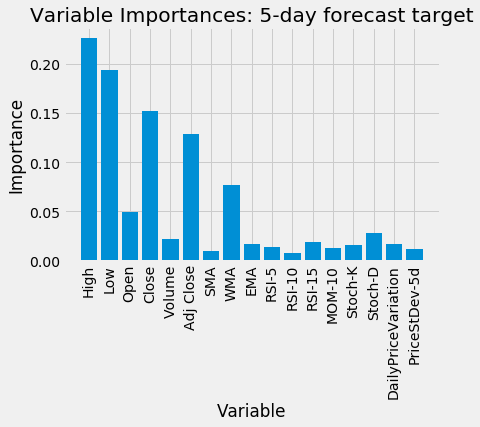

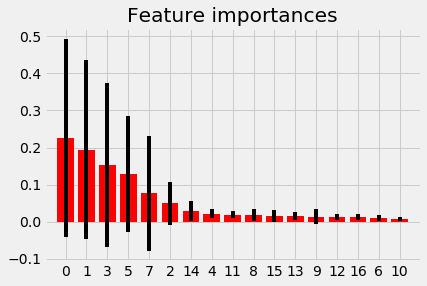

15-day
Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30
Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Validation Features Shape: (46, 17)
Validation Labels Shape: (46,)
Feature ranking:
1. feature 0 (0.225747)
2. feature 1 (0.193748)
3. feature 3 (0.152291)
4. feature 5 (0.128996)
5. feature 7 (0.076558)
6. feature 2 (0.049137)
7. feature 14 (0.028148)
8. feature 4 (0.021435)
9. feature 11 (0.018623)
10. feature 8 (0.017328)
11. feature 15 (0.016423)
12. feature 13 (0.015720)
13. feature 9 (0.013367)
14. feature 12 (0.012791)
15. feature 16 (0.011989)
16. feature 6 (0.009657)
17. feature 10 (0.008042)


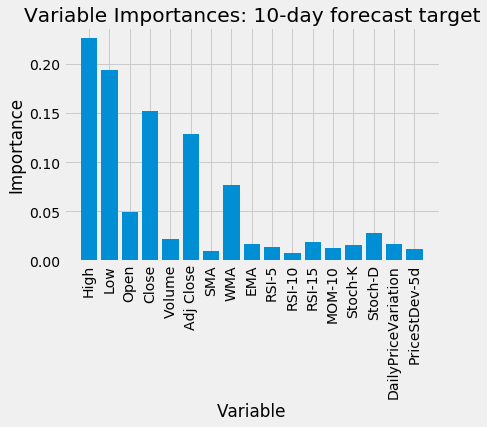

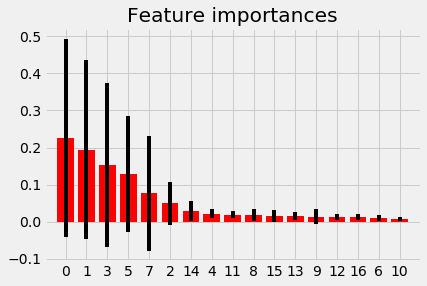

20-day
Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30
Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Validation Features Shape: (46, 17)
Validation Labels Shape: (46,)
Feature ranking:
1. feature 0 (0.225747)
2. feature 1 (0.193748)
3. feature 3 (0.152291)
4. feature 5 (0.128996)
5. feature 7 (0.076558)
6. feature 2 (0.049137)
7. feature 14 (0.028148)
8. feature 4 (0.021435)
9. feature 11 (0.018623)
10. feature 8 (0.017328)
11. feature 15 (0.016423)
12. feature 13 (0.015720)
13. feature 9 (0.013367)
14. feature 12 (0.012791)
15. feature 16 (0.011989)
16. feature 6 (0.009657)
17. feature 10 (0.008042)


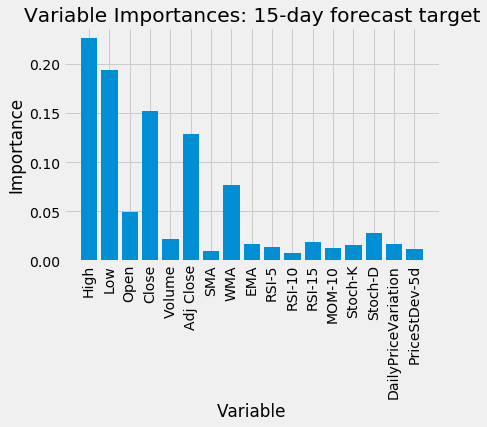

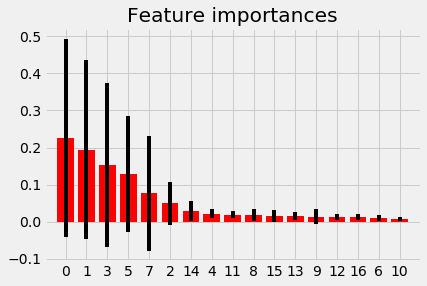

30-day
Data series total days: 230
Data series train/test split at: 184
Data series train/test split at: 2014-10-24
Training set: 2014-01-23 - 2014-10-22
Test set: 2014-10-24 - 2014-12-30
Training Features Shape: (138, 17)
Training Labels Shape: (138,)
Validation Features Shape: (46, 17)
Validation Labels Shape: (46,)
Feature ranking:
1. feature 0 (0.225747)
2. feature 1 (0.193748)
3. feature 3 (0.152291)
4. feature 5 (0.128996)
5. feature 7 (0.076558)
6. feature 2 (0.049137)
7. feature 14 (0.028148)
8. feature 4 (0.021435)
9. feature 11 (0.018623)
10. feature 8 (0.017328)
11. feature 15 (0.016423)
12. feature 13 (0.015720)
13. feature 9 (0.013367)
14. feature 12 (0.012791)
15. feature 16 (0.011989)
16. feature 6 (0.009657)
17. feature 10 (0.008042)


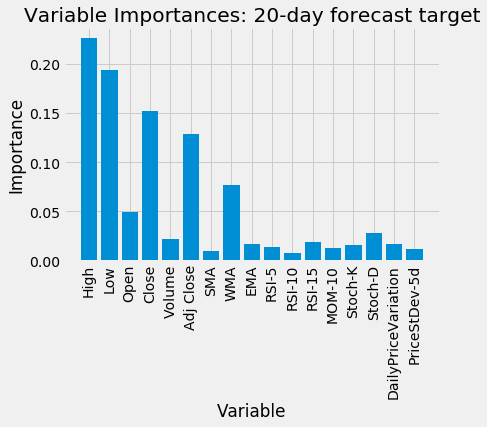

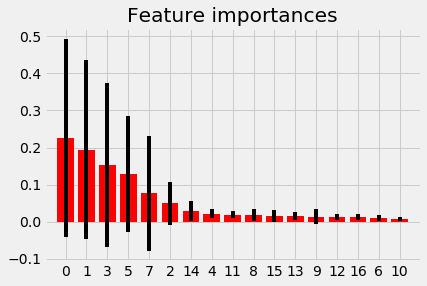

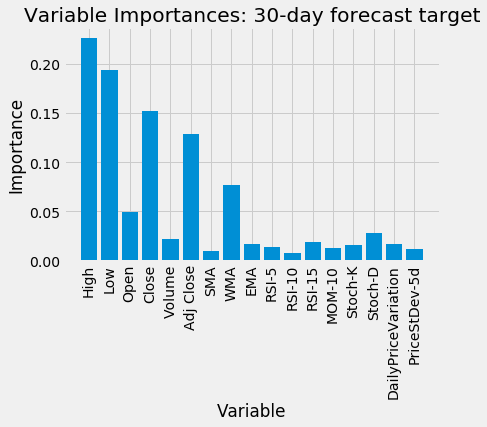

In [20]:
h = ['1-day', '3-day', '5-day', '10-day', '15-day', '20-day', '30-day']

print("="*50)
for forecast_target in h:
    print(forecast_target)
    train, test = split_data_fwdchaining(daily)
    train_labels = get_label(train)
    train = remove_label(train) # Remove labels from dataframe before fitting
    rf, train_features = train_model(train, train_labels, target_horizon=forecast_target)
    plot_var_importance(rf, train_features, target_desc="%s forecast target" % forecast_target)
    print("="*50)

In [21]:
train

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,EMA,RSI-5,RSI-10,RSI-15,MOM-10,Stoch-K,Stoch-D,DailyPriceVariation,PriceStDev-5d
Date,,,,,,,,,,,,,,,,,
2014-01-23,156.5,150.5,151.5,156.5,14332200.0,117.656586,149.6,151.100000,149.6,87.410327,81.538550,79.069767,14.5,82.222222,72.475634,0.038339,4.144273
2014-01-24,157.0,153.5,156.5,155.0,7609400.0,116.528893,151.2,152.900000,151.2,77.410551,77.101931,76.220977,13.5,90.000000,80.370370,0.022581,4.424364
2014-01-27,152.5,150.5,152.0,150.5,6392900.0,113.145844,151.9,152.666667,151.9,54.171080,65.264789,68.310184,3.5,76.388889,82.870370,0.013289,3.830796
2014-01-28,149.5,145.5,148.5,147.0,11064100.0,110.514511,151.9,151.033333,151.9,41.932252,57.619963,62.872373,-1.5,48.611111,71.666667,0.027211,3.830796
2014-01-29,147.0,145.0,147.0,146.0,12681700.0,109.762726,151.0,149.066667,151.0,38.801406,55.554133,61.376698,2.0,23.611111,49.537037,0.013699,4.677072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-16,175.0,172.5,175.0,172.5,6276200.0,133.796844,175.8,175.066667,175.8,16.165537,23.974210,29.526705,-7.0,18.518519,27.469136,0.014493,1.987461
2014-10-17,174.0,172.0,173.5,173.0,6936500.0,134.184677,174.9,174.133333,174.9,22.182688,26.607418,31.115706,-8.0,8.831909,18.993352,0.011561,2.043282
2014-10-20,175.5,174.0,174.5,174.5,7187000.0,135.348114,174.5,174.000000,174.5,38.685644,34.203752,35.770682,-3.0,17.948718,15.099715,0.008596,1.837117


In [30]:
# Features Correlation

train.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'SMA', 'WMA',
       'EMA', 'RSI-5', 'RSI-10', 'RSI-15', 'MOM-10', 'Stoch-K', 'Stoch-D',
       'DailyPriceVariation', 'PriceStDev-5d'],
      dtype='object')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.api as smg

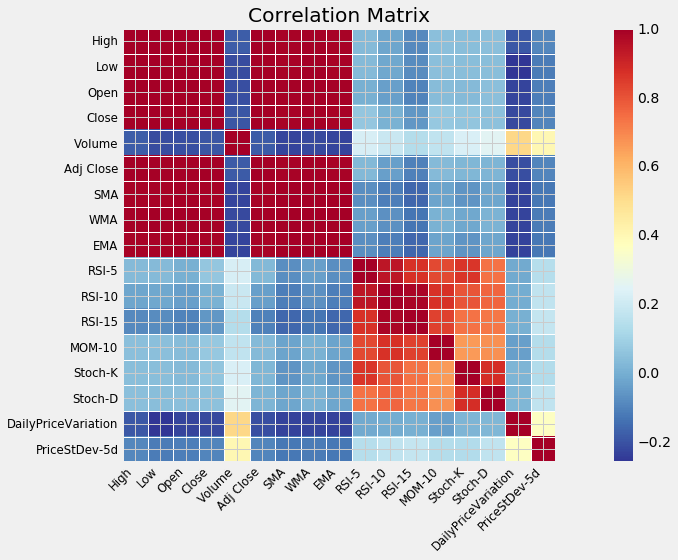

In [33]:
corr_matrix = np.corrcoef(train.T)
smg.plot_corr(corr_matrix, xnames=train.columns)
plt.rc("figure", figsize=(20,20))
plt.show()